In [1]:
%matplotlib notebook
import numpy as np
import os
import pandas
import quaternion
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
import pre_processing.gen_dataset as gen_dataset
from utility.write_trajectory_to_ply import write_ply_to_file

nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 10

In [2]:
dir_source = '../../data_multi/hang_legpocket_lopata/pixel'
dir_target = '../../data_multi/hang_legpocket_lopata/phab'
filter_sigma = 10.0

In [3]:
# Compute the time offset between the source and target data with the Y-axis gyroscope signal.
# This method requires the subject making a significant side turn priori to data capturing.
gyro_source = np.genfromtxt(dir_source + '/gyro.txt')
gyro_target = np.genfromtxt(dir_target + '/gyro.txt')

In [12]:
best_offset_hang_handheld_lopata = 584
best_offset_hang_body_lopata = 1036
best_offset_hang_body_cse = 696
best_offset_hang_handheld_cse = 670
best_offset_iphone_duc1 = -165
best_offset_iphone_cse1 = -202
best_offset_hang_bag_cse = -1670
best_offset_hang_leg_cse = -1230
best_offset_hang_leg_cse2 = -3410
best_offset_hang_legpocket_lopata = -3060

<IPython.core.display.Javascript object>


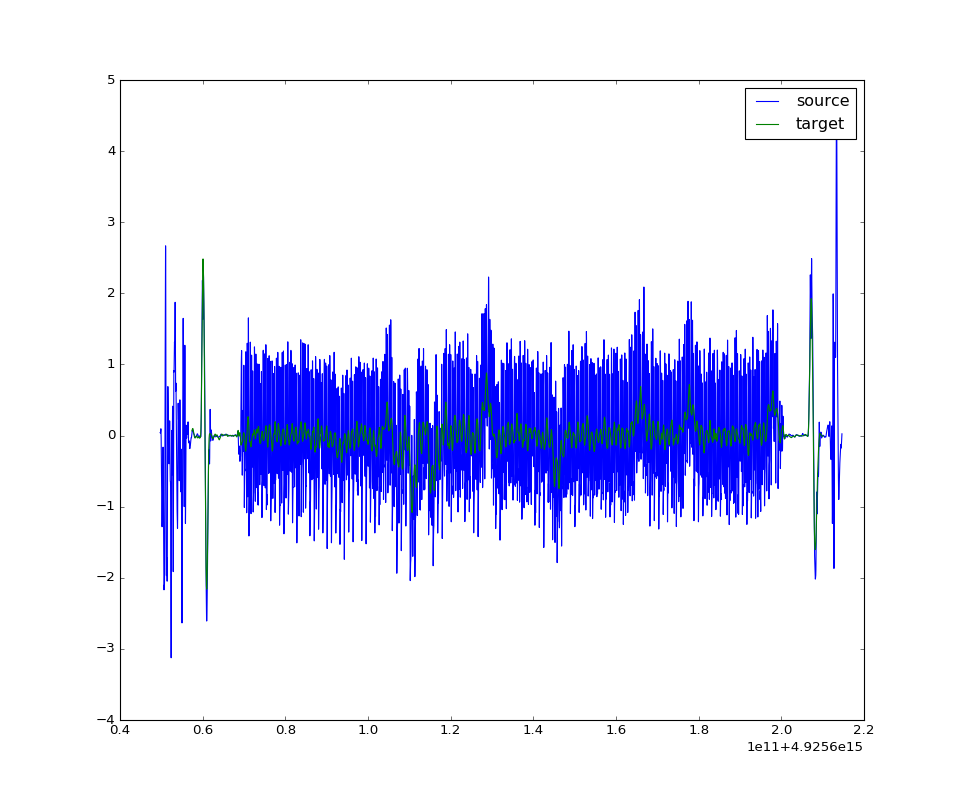

In [8]:
gyro_source = gaussian_filter1d(gyro_source, sigma=filter_sigma, axis=0)
gyro_target = gaussian_filter1d(gyro_target, sigma=filter_sigma, axis=0)

test_offset = -3060
time_offset = 0 # the time offset is defined as target - source
if test_offset >= 0:
    time_offset = gyro_target[test_offset, 0] - gyro_source[0, 0]
else:
    time_offset = gyro_target[0, 0] - gyro_source[-test_offset, 0]

sync_chn = 2
sync_source = np.copy(gyro_source)
sync_source[:, 0] += time_offset
truncate = -1
plt.figure('Synchronize')
plt.plot(sync_source[:truncate, 0], sync_source[:truncate, sync_chn])
plt.plot(gyro_target[:truncate, 0], gyro_target[:truncate, sync_chn])
plt.legend(['source', 'target'])

In [197]:
skip_front_hang_body_lopata = 1800
skip_end_hang_body_lopata = 900

skip_front_hang_handheld_lopata = 2200
skip_end_hang_handheld_lopata = 2000

skip_front_hang_body_cse = 2000
skip_end_hang_body_cse = 1200

skip_front_hang_handheld_cse = 1000
skip_front_hang_body_cse = 800

skip_front_hang_bag_cse = 1400
skip_end_hang_bag_cse = 1400

skip_front_hang_leg_cse = 1400
skip_end_hang_leg_cse = 1400

In [11]:
# Use estimated time_offset
skip_front = 1200
skip_end = 1400
estimate_skip = False

sample_rate = lambda x: x.shape[0] / (x[-1, 0] - x[0, 0]) * nano_to_sec
gyro_source = np.genfromtxt(dir_source + '/gyro.txt')
print('Gyroscope: {:.2f}Hz'.format(sample_rate(gyro_source)))
acce_source = np.genfromtxt(dir_source + '/acce.txt')
print('Accelerometer: {:.2f}Hz'.format(sample_rate(acce_source)))
linacce_source = np.genfromtxt(dir_source + '/linacce.txt')
print('Linear acceleration: {:.2f}Hz'.format(sample_rate(linacce_source)))
gravity_source = np.genfromtxt(dir_source + '/gravity.txt')
print('Gravity: {:.2f}Hz'.format(sample_rate(gravity_source)))
magnet_source = np.genfromtxt(dir_source + '/magnet.txt')
print('Magnetometer: {:.2f}Hz'.format(sample_rate(magnet_source)))
rv_source = np.genfromtxt(dir_source + '/orientation.txt')
print('Rotation vector: {:.2f}Hz'.format(sample_rate(rv_source)))
ar_pose = np.array([])
#if os.path.exists(dir_source + '/pose.txt'):
#    ar_pose = np.genfromtxt(dir_source + '/pose.txt')
    
gyro_source[:, 0] += time_offset
acce_source[:, 0] += time_offset
linacce_source[:, 0] += time_offset
gravity_source[:, 0] += time_offset
magnet_source[:, 0] += time_offset
rv_source[:, 0] += time_offset
rv_source[:, [1, 2, 3, 4]] = rv_source[:, [4, 1, 2, 3]]
if ar_pose.shape[0] > 0:
    ar_pose[:, 0] += time_offset

# Interpolate to the reference pose timestamp
pose_ref = np.genfromtxt(dir_target + '/pose.txt')[skip_front:-skip_end]
min_pose_ind, max_pose_ind = 0, pose_ref.shape[0] - 1
max_timestamp = min([gyro_source[-1, 0], acce_source[-1, 0], linacce_source[-1, 0],
                     gravity_source[-1, 0], magnet_source[-1, 0], rv_source[-1, 0]])
min_timestamp = max([gyro_source[0, 0], acce_source[0, 0], linacce_source[0, 0],
                     gravity_source[0, 0], magnet_source[0, 0], rv_source[0, 0]])

if ar_pose.shape[0] > 0:
    min_timestamp = min([min_timestamp, ar_pose[0, 0]])
    max_timestamp = max([max_timestamp, ar_pose[-1, 0]])
while pose_ref[min_pose_ind, 0] <= min_timestamp:
    min_pose_ind += 1
while pose_ref[max_pose_ind, 0] >= max_timestamp:
    max_pose_ind -= 1

unique_ts, unique_inds = np.unique(pose_ref[:, 0], return_index=True)
print('Portion of unique records: ', unique_inds.shape[0] / pose_ref.shape[0])
pose_ref = pose_ref[unique_inds, :]
output_timestamp = pose_ref[:, 0]
output_samplerate = output_timestamp.shape[0] * nano_to_sec / (output_timestamp[-1] - output_timestamp[0])
assert 195 < output_samplerate < 205, 'Wrong output sample rate: %f' % output_samplerate

output_gyro = gen_dataset.interpolate_3dvector_linear(gyro_source[:, 1:], gyro_source[:, 0], output_timestamp)
if estimate_skip:
    plt.figure('Output gyro')
    for i in range(output_gyro.shape[1]):
        plt.subplot(311+i)
        plt.plot(output_gyro[:, i])  
else:
    output_acce = gen_dataset.interpolate_3dvector_linear(acce_source[:, 1:], acce_source[:, 0], output_timestamp)
    output_linacce = gen_dataset.interpolate_3dvector_linear(linacce_source[:, 1:], linacce_source[:, 0],
                                                             output_timestamp)
    output_gravity = gen_dataset.interpolate_3dvector_linear(gravity_source[:, 1:], gravity_source[:, 0],
                                                             output_timestamp)
    output_magnet = gen_dataset.interpolate_3dvector_linear(magnet_source[:, 1:], magnet_source[:, 0],
                                                            output_timestamp)
    output_rv = gen_dataset.interpolate_quaternion_linear(rv_source[:, 1:], rv_source[:, 0], output_timestamp)

    # fake position and orientation data
    output_position = np.zeros([output_timestamp.shape[0], 3])
    output_orientation = output_rv
    if ar_pose.shape[0] > 0:
        output_position = gen_dataset.interpolate_3dvector_linear(ar_pose[:, [1, 2, 3]], ar_pose[:, 0],
                                                                  output_timestamp)
        output_orientation = gen_dataset.interpolate_quaternion_linear(ar_pose[:, [-1, -4, -3, -2]], ar_pose[:, 0],
                                                                       output_timestamp)

    column_list = 'time,gyro_x,gyro_y,gyro_z,acce_x'.split(',') + \
                  'acce_y,acce_z,linacce_x,linacce_y,linacce_z,grav_x,grav_y,grav_z'.split(',') + \
                  'magnet_x,magnet_y,magnet_z'.split(',') + \
                  'pos_x,pos_y,pos_z,ori_w,ori_x,ori_y,ori_z,rv_w,rv_x,rv_y,rv_z'.split(',')
    data_mat = np.concatenate([output_timestamp[:, None], output_gyro, output_acce, output_linacce,
                               output_gravity, output_magnet, output_position, output_orientation,
                               output_rv], axis=1)
    output_data = pandas.DataFrame(data=data_mat, columns=column_list, dtype=float)
    print('Writing csv...')
    output_dir = dir_source + '/processed'
    os.makedirs(output_dir, exist_ok=True)

    output_data.to_csv(output_dir + '/data.csv')
    

    # write data in plain text file for C++
    with open(output_dir + '/data_plain.txt', 'w') as f:
        f.write('{} {}\n'.format(data_mat.shape[0], data_mat.shape[1]))
        for i in range(data_mat.shape[0]):
            for j in range(data_mat.shape[1]):
                f.write('{}\t'.format(data_mat[i][j]))
            f.write('\n')

    print('All done')

Gyroscope: 395.66Hz
Accelerometer: 395.66Hz
Linear acceleration: 200.01Hz
Gravity: 200.01Hz
Magnetometer: 49.46Hz
Rotation vector: 200.01Hz
Portion of unique records:  0.9968324020358046
Writing csv...
All done
